<a href="https://colab.research.google.com/github/Jeongrnin/Computer-vision/blob/cnn/%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Packages

In [6]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

MNIST train, test dataset 가져오기

In [7]:
# "": 현재 폴더에 MNIST 있음
mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(), #train 용으로 쓰겠다.
                       target_transform=None, download=True)
mnist_test=dset.MNIST("", train=False,transform=transforms.ToTensor(), #test 용으로 쓰겠다.
                      target_transform=None, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17879434.78it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 555849.35it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3776942.48it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5154363.84it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



대략적인 데이터 형태

mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태: torch.Size([1, 28, 28])
label:  5


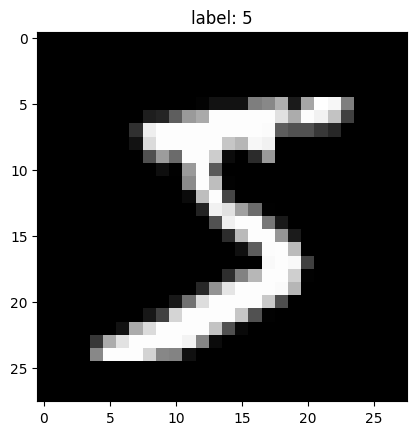

In [8]:
print ("mnist_train 길이:", len(mnist_train))
print ("mnist_test 길이:", len(mnist_test))

#데이터 하나 형태
image, label = mnist_train.__getitem__(0) #0번째 데이터
print ("image data 형태:", image.size())
print ("label: ", label)

#그리기
img = image.numpy() #image 타입을 numpy 로 변환 (1,28,28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

MNIST data 띄워보기

5
torch.Size([1, 28, 28])
5


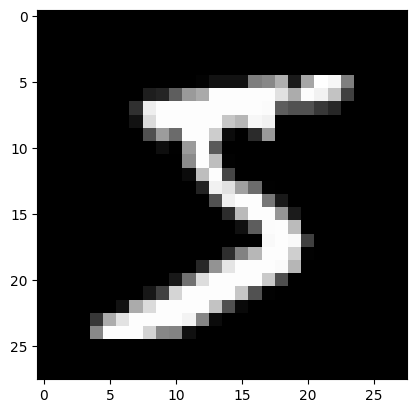

0


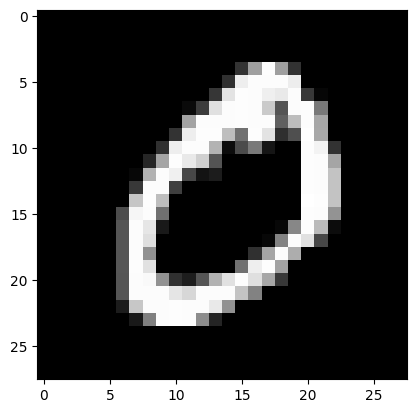

4


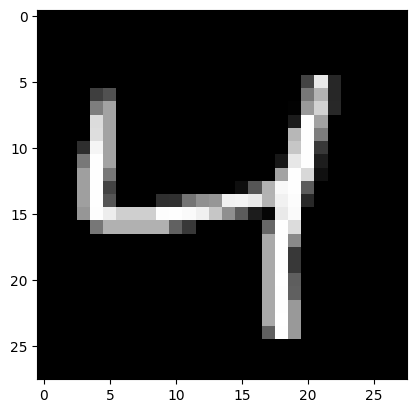

In [9]:
print(mnist_train[0][1]) #label
print(mnist_train[0][0].size()) #image

for i in range(3):
  img=mnist_train[i][0].numpy()
  print(mnist_train[i][1])
  plt.imshow(img[0],cmap='gray')
  plt.show()

convolution 하나 씌워보기

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


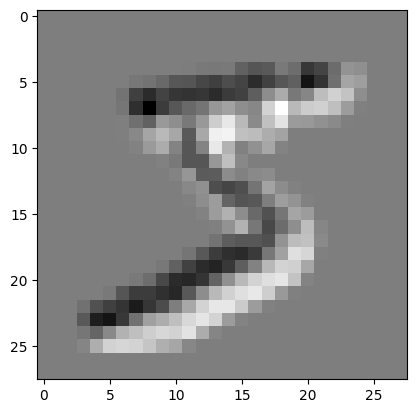

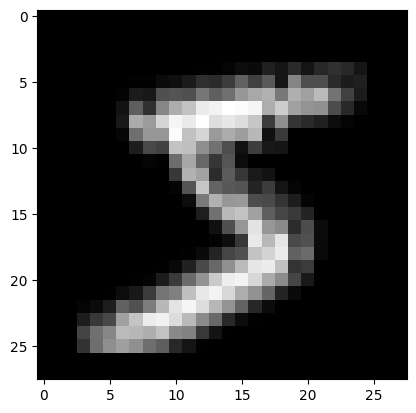

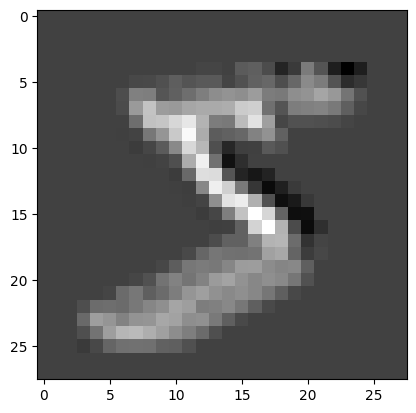

In [10]:
#mnist의 첫번째 이미지, 라벨 가져ㅗ기
image, label = mnist_train[0]
#view: tensor의 사이즈 조절. -1: 해당 차원 차원 확장시켜라
#[1,28,28]->[1,1,28,28]
image=image.view(-1, image.size()[0], image.size()[1], image.size()[2])
print(image.size())

print(label)

#convolutional filter 정의
conv_layer=nn.Conv2d(in_channels=1, out_channels=3,kernel_size=3,padding=1)
#image에 filter 적용
output=conv_layer(Variable(image))
print(output.size())

for i in range(3):
  plt.imshow(output[0,i,:,:].data.numpy(), cmap='gray')
  plt.show()

CNN 만들기
train, test data 가져오기

In [11]:
import numpy as np
import torch.optim as optim

batch_size = 16
learning_rate = 0.0002
num_epoch = 10 # 1000

In [12]:
# 후에 학습시킬 때 batch_size 단위로 학습시켜나감
train_loader = torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], batch_size=batch_size, #mnist_train를 트레인 시키
                                           shuffle=True, num_workers=2,
                                           drop_last=True) #batch_size 만큼 나눌 때 나머지는 버려라
test_loader = torch.utils.data.DataLoader((mnist_test), batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          drop_last=True)

CNN 클래스 만들기(모델 만들기)

In [13]:
class CNN(nn.Module): #nn.Module 상속받음
  def __init__(self):
    super(CNN, self).__init__() # 28 x 28
    self.layer=nn.Sequential(
        nn.Conv2d(1, 16, 5, padding=2),
        nn.ReLU(),

        nn.Conv2d(16, 32, 5, padding=2), # 28 x 28
        nn.ReLU(),
        nn.MaxPool2d(2,2), # 28 x 28 -> 14 x 14

        nn.Conv2d(32, 64, 5, padding=2), # 14 x 14
        nn.ReLU(),
        nn.MaxPool2d(2,2) # 14 x 14 -> 7 x 7
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*7*7, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)
    return out

model = CNN().cuda()

In [14]:
# 파라미터 체크하기
for parameter in model.parameters():
  #print(parameter)
  print(parameter.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [15]:
# loss function, optimizer 선언
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Optimization

In [16]:
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader): #batch_size 만큼
    x = Variable(image).cuda()
    y_ = Variable(label).cuda()

    optimizer.zero_grad() # optimizer 안에서 이전 gradient 들을 초기화.
    output=model.forward(x)
    loss = loss_func(output, y_)
    loss.backward() # gradient 계산
    optimizer.step() # parameter 업데이트

    if j%50==0:
      print(loss, j, i)

tensor(2.2990, device='cuda:0', grad_fn=<NllLossBackward0>) 0 0
tensor(1.5198, device='cuda:0', grad_fn=<NllLossBackward0>) 50 0
tensor(0.5483, device='cuda:0', grad_fn=<NllLossBackward0>) 0 1
tensor(0.3360, device='cuda:0', grad_fn=<NllLossBackward0>) 50 1
tensor(0.1414, device='cuda:0', grad_fn=<NllLossBackward0>) 0 2
tensor(0.0699, device='cuda:0', grad_fn=<NllLossBackward0>) 50 2
tensor(0.2303, device='cuda:0', grad_fn=<NllLossBackward0>) 0 3
tensor(0.0943, device='cuda:0', grad_fn=<NllLossBackward0>) 50 3
tensor(0.1190, device='cuda:0', grad_fn=<NllLossBackward0>) 0 4
tensor(0.4513, device='cuda:0', grad_fn=<NllLossBackward0>) 50 4
tensor(0.0722, device='cuda:0', grad_fn=<NllLossBackward0>) 0 5
tensor(0.0925, device='cuda:0', grad_fn=<NllLossBackward0>) 50 5
tensor(0.0836, device='cuda:0', grad_fn=<NllLossBackward0>) 0 6
tensor(0.0605, device='cuda:0', grad_fn=<NllLossBackward0>) 50 6
tensor(0.0076, device='cuda:0', grad_fn=<NllLossBackward0>) 0 7
tensor(0.0407, device='cuda:0', g

In [17]:
# 모델 저장시키기
torch.save(model, 'nets/mycnn_model_%d.pkl'%(num_epoch))

In [18]:
try:
  # 미리 학습시킨 네트워크의 파라미터 집합 [피클]이라 발음함.
  model=torch.load('nets/mycnn_model_10.pkl')
  print("model restored")
except:
  print("model not restored")

model restored


In [25]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    imodel.to(device)
    imodel.eval()

    with torch.no_grad():
        for imgs, labels in dloader:
            imgs, labels = imgs.to(device), labels.to(device)

            output = imodel(imgs)  # forward prop.
            _, output_index = torch.max(output, 1)

            total += labels.size(0)
            correct += (output_index == labels).sum().item()
    print("Accuracy of Test Data: {:.2f}%".format(100 * correct / total))

In [26]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 94.74%
